# Neutron Burst

The neutron burst is a neutron capture nucleosynthesis that sits somewhere in between the s- and r-processes. Neutron bursts can achieve rather high neutron densities
($\sim 10^{17}$ neutrons/cm$^3$) for times of order several tenths of a second. Importantly, due to the short duration of the burst, we can largeley ignore beta decay for its duration.

For a glimpse at this kind of network, consider the following neutron capture chain:
\begin{gather}
1 + n \rightarrow 2 + \gamma\notag\\
2 + n \rightarrow 3 + \gamma\notag\\
3 + n \rightarrow 4 + \gamma\notag
\end{gather}
The coupled differential equations governing the evolution of this network are:
\begin{gather}
\frac{dY_1}{d\tau} = -\sigma_{n,1} Y_1\\
\frac{dY_2}{d\tau} = \sigma_{n,1} Y_1 - \sigma_{n,2}Y_2\\
\frac{dY_3}{d\tau} = \sigma_{n,2} Y_2 - \sigma_{n,3}Y_3\\
\frac{dY_4}{d\tau} = \sigma_{n,3} Y_3 
\end{gather}
where the $Y$'s are abundances and $\sigma_{n, i}$ are the neutron capture cross sections for each species.  $\tau$ is a useful parameter that represents the total neutron fluence over the duration of the burst. It is defined as
\begin{gather}
\tau(t) = \int_0^t n_n(t') v_T(t') dt'
\end{gather}
with $n_n$ the neutron density and $v_T$ the neutron thermal velocity.  The cross sections are typically given in terms of millibarns ($mb$), so the exposure is presented in terms of inverse millibarns ($mb^{-1}$). $v_T$ itself is given by
\begin{gather}
v_T = \sqrt{\frac{2k_BT}{m_n}}
\end{gather}
which is the most probable velocity in a Maxwell-Boltzmann distribution.

For simplicity, this notebook considers an isolated reaction chain. In other words the only reactions considered are neutron captures along the chain and out of the chain.  Cross sections are computed from imported network data giving thermally-averaged neutron capture rates $N_A \langle \sigma v\rangle$, with $N_A$ Avogadro's number.  Then $\sigma_n = \langle \sigma v \rangle / v_T$.  With cross sections and initial abundances available, the notebook solves the network equations numerically to obtain the mass fractions as a function of exposure.

## Preliminaries 

Begin by importing the necessary libraries:

In [1]:
import sys, subprocess, pkg_resources
import os, io, requests
required = {'numpy','wnutils', 'wnnet', 'matplotlib', 'gslconsts', 'scipy', 'ipywidgets', 'xmlcoll'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])

import wnnet as wn 
import wnutils.xml as wx
import matplotlib.pyplot as plt
import ipywidgets as widgets
import re
from ipywidgets import interact, fixed
from IPython.display import display 
import numpy as np
from gslconsts.consts import *
from scipy.integrate import solve_ivp

/var/folders/c2/jl4x17sd3xvbl02c884dn8xw0000gn/T/ipykernel_47946/1025401542.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import sys, subprocess, pkg_resources


Now define some functions for use in the notebook.  First define the differential equations for the network evolution.

In [2]:
def dYdt(t, y, sigs):
    N = len(y)
    result = np.zeros(N)
    result[0] = -sigs[0]*y[0]
    for i in range(1, N):
        result[i] = sigs[i-1]*y[i-1] - sigs[i]*y[i]
    return result

Now define a function to retrieve the solar abundances from an XML data file.

In [3]:
def get_solar_abundances(solar_xml):    
    solar_data = solar_xml.get_zone_data()
    x_solar = solar_data["0"]["mass fractions"]
    
    result = {}
    
    for tup, value in x_solar.items():
        result[tup[0]] = value / tup[2]
            
    return result

Now define a function to retrieve cross sections.

In [4]:
def get_sigs(net, t9):
    
    v_T = np.sqrt((2. * GSL_CONST_CGS_BOLTZMANN * t9 * 1.e9) / GSL_CONST_CGS_MASS_NEUTRON)

    reacs = net.get_reactions(reac_xpath="[reactant = 'n' and product = 'gamma']")
    
    result = {}
    for reac in reacs.values():
        reactant = ""
        for r in reac.reactants:
            if r != "n":
                reactant = r
                break
        result[reactant] = reac.compute_rate(t9) / (v_T * GSL_CONST_NUM_AVOGADRO * 1.e-3 * GSL_CONST_CGS_BARN)
        
    return result

Now, import the data that will be used throughout this notebook. Execution of this cell will take a few minutes. The *solar_xml* object contains the mass fractions of isotopes in the solar system and the *net* object contains the nuclear reaction network data.

In [5]:
solar_xml = wx.Xml(io.BytesIO(requests.get("https://osf.io/j67qa/download").content))
net = wn.net.Net(io.BytesIO(requests.get('https://osf.io/vqhxr/download').content))

## Set the network, grain data (if desired), and solar abundances.
In this section, define a network by setting the list of species in the isotope chain.  Also define the normalizing species.

In [6]:
species = ['ni56','ni57','ni58','ni59','ni60','ni61','ni62','ni63','ni64']
normalizing_species = 'ni58'

It is possible to compare the network calculations to presolar grain data.  To do so, add the grain data here.  Construct an array of grains.  For each grain, construct a dictionary that provides the mass number, the abundance relative to solar (and relative to the same ratio for the normalizing species), and the error.  In the example below, data are shown for a silicon nitride grain.  The data are abundance relative to solar compare to the same ratio for the normalizing species $^{58}$Ni.  Adjust and/or add appropriate data.

In [7]:
grains = [
    {'name': 'C grain',
     'a': [60, 61, 62, 63, 64],
     'data': [1.44, 9.25, 9.02, 6.58, 22.27],
     'error': [0.07, 0.81, 0.50, 0.36, 1.29]
    }
]

for g in grains:
    assert len(g['a']) == len(g['data']) == len(g['error'])

The following cell retrieves data about the isotope chain.

In [8]:
nucs = net.get_nuclides()
a = [nucs[sp]['a'] for sp in species]
element = re.findall(r"\{(.*?)\}", solar_xml.get_latex_names(species)[species[0]])[1]

Now get the solar abundances and print out those abundances for species in the network.

In [9]:
dict_solar = get_solar_abundances(solar_xml)

for sp in species:
    if sp in dict_solar:
        print(sp, dict_solar[sp])

ni58 9.516363546660246e-07
ni60 3.664886388455985e-07
ni61 1.5938103109707244e-08
ni62 5.079722036983758e-08
ni64 1.2925947843102022e-08


Now modify the solar abundances if desired.  The example shows setting the $^{63}$Ni solar abundance to that of its daughter $^{63}$Cu.

In [10]:
dict_solar['ni63'] = dict_solar['cu63']

Print out the modified solar abundances and set the mass number array.

In [11]:
a_solar = []
for sp in species:
    if sp in dict_solar:
        print(f"{sp}    {dict_solar[sp]:.3e}")
        a_solar.append(nucs[sp]['a'])

ni58    9.516e-07
ni60    3.665e-07
ni61    1.594e-08
ni62    5.080e-08
ni63    1.066e-08
ni64    1.293e-08


## Set the initial network abundances
In this section, define the initial abundances for the network.  These are taken to be the solar abundances by default, but they can be modified if desired.

In [12]:
initial_abunds = []
for sp in species:
    if sp in dict_solar:
        initial_abunds.append(dict_solar[sp])
    else:
        initial_abunds.append(0)

Print out the initial (solar) abundances for each isotope in the network.

In [13]:
for i, sp in enumerate(species):
    print(f"{sp}    {initial_abunds[i]:.3e}")

ni56    0.000e+00
ni57    0.000e+00
ni58    9.516e-07
ni59    0.000e+00
ni60    3.665e-07
ni61    1.594e-08
ni62    5.080e-08
ni63    1.066e-08
ni64    1.293e-08


Modify the initial abundances.  The commented examples show how to do this.  The first increases the existing abundance by a factor.  The second resets an initial abundance.  Uncomment and adjust/add modifications.

In [14]:
#initial_abunds[species.index('ni58')] *= 1.1  # Increase ni58 abundance by 10%
#initial_abunds[species.index('ni63')] = 0 # Reset ni63 abundance

Print out the adjusted initial abundances.

In [15]:
for i, sp in enumerate(species):
    print(f"{sp}    {initial_abunds[i]:.3e}")

ni56    0.000e+00
ni57    0.000e+00
ni58    9.516e-07
ni59    0.000e+00
ni60    3.665e-07
ni61    1.594e-08
ni62    5.080e-08
ni63    1.066e-08
ni64    1.293e-08


Finally, plot the initial abundances.

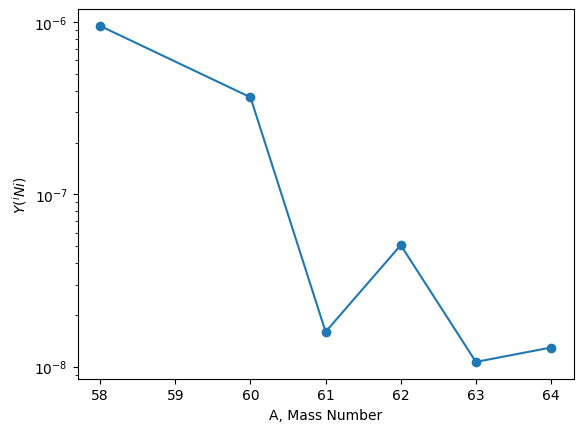

In [16]:
fig, ax = plt.subplots()
plot_a = []
plot_abunds = []
for i, sp in enumerate(species):
    if initial_abunds[i] != 0:
        plot_a.append(a[i])
        plot_abunds.append(initial_abunds[i])
ax.plot(plot_a, plot_abunds, 'o-')
ax.set_xlabel("A, Mass Number")
ax.set_ylabel(f"$Y(^i{element}$)")
ax.set_yscale('log')
plt.show()

## Cross sections
In this section, compute the cross sections and modify them if desired.  First, define a temperature in $10^9$K to be used to compute the reaction rates.

In [17]:
t9 = 0.8

Now, we compute the reaction rates for all neutron capture reactions at the provided temperature and print them out for the network.

In [18]:
sigs = get_sigs(net, t9)

for sp in species:
    print(f"{sp}    {sigs[sp]:.3f} mb")

ni56    20.583 mb
ni57    34.940 mb
ni58    28.353 mb
ni59    51.162 mb
ni60    17.928 mb
ni61    44.590 mb
ni62    11.287 mb
ni63    15.018 mb
ni64    5.315 mb


## Compute abundances and compare to grain data.
In this sections, evolve the network abundances and compare to grain data.  First compute the abundances for a given exposure ($\tau$) and compare to the initial abundances.  Vary the exposure by changing the value of $\tau$ in the text box.

In [29]:
def compute_abundances(tau, species, sigmas, initial_abunds):
    
    sigs_array = [sigmas[sp] for sp in species]

    sol = solve_ivp(dYdt, (0, tau), initial_abunds, args=(sigs_array,), max_step=0.001)
    
    print(f"For tau (mb^{-1}) = {tau:.3f}:\n")
        
    for i in range(len(species)):
        print(f"{species[i]}:   Y(0) = {initial_abunds[i]:.3e},   Y(tau) = {sol.y[i, -1]:.3e}")
        

interact(
    compute_abundances,
    tau=widgets.BoundedFloatText(value=0.01, min=0.0, max=1, step=0.01, description='$\\tau$ (mb-1)'),
    species=fixed(species),
    sigmas=fixed(sigs),
    initial_abunds=fixed(initial_abunds)
)

interactive(children=(BoundedFloatText(value=0.01, description='$\\tau$ (mb-1)', max=1.0, step=0.01), Output()…

<function __main__.compute_abundances(tau, species, sigmas, initial_abunds)>

Now plot the abundances.  Shown are the initial abundances and the abundances after exposure $\tau$.

In [27]:
def plot_abundances(tau, species, a, sigmas, initial_abunds):

    sigs_array = [sigmas[sp] for sp in species]

    sol = solve_ivp(dYdt, (0, tau), initial_abunds, args=(sigs_array,), max_step=0.001)
    
    plt.plot(a, sol.y[:,-1], 'o-', label="Final abundances")
    plt.plot(a, initial_abunds, 'o:', label="Initial abundances")
    plt.xlabel('A, Mass Number')
    plt.ylabel('Abundance per nucleon')
    plt.legend()
    plt.title('$\\tau$ = {:.3f} $mb^{{-1}}$'.format(tau))

x = interact(
    plot_abundances,
    tau=widgets.BoundedFloatText(value=0.01, min=0.0, max=1, step=0.01, description='$\\tau (mb^{-1}):$'),
    a=fixed(a),
    species=fixed(species),
    sigmas=fixed(sigs),
    initial_abunds=fixed(initial_abunds)
)

display(x)

interactive(children=(BoundedFloatText(value=0.01, description='$\\tau (mb^{-1}):$', max=1.0, step=0.01), Outp…

<function __main__.plot_abundances(tau, species, a, sigmas, initial_abunds)>

Compare the evolved abundances to solar (relative to the normalizing species).  Grain data can be optionally displayed with the checkbox. Additionally, if one would like to compare the results of a different set of nuclear capture cross sections one can create the sigmas_mod dictionary and uncomment the lines in the plot_vs_solar function. 

In [28]:
sigmas_mod = {}
#for sp in species:
#    sigmas_mod[sp] = sigs[sp]
#sigmas_mod['ni63'] *= 4.5

def plot_vs_solar(tau, species, sigmas, sigs_mod, initial_abunds, dict_solar, show_grain):
    
    sigs_array = [sigmas[sp] for sp in species]
#    sigs_mod_array = [sigs_mod[sp] for sp in species]

    sol = solve_ivp(dYdt, (0, tau), initial_abunds, args=(sigs_array,), max_step=0.001)
#    sol_mod = solve_ivp(dYdt, (0, tau), initial_abunds, args = (sigs_mod_array,), max_step = 0.001)

    f = dict_solar[normalizing_species]/sol.y[species.index(normalizing_species),-1]
    sol_normalized = []
#    sol_mod_normalized = []
    for i in range(len(sol.y)):
        if species[i] in dict_solar:
            sol_normalized.append((sol.y[i,-1]/dict_solar[species[i]])*f)
#            sol_mod_normalized.append((sol_mod.y[i,-1]/dict_solar[species[i]])*f)

    fig, ax = plt.subplots() 
    ax.plot(a_solar, np.array(sol_normalized), 'o-', label = r'Network')
#    ax.plot(a_solar, np.array(sol_mod_normalized), 'o-', label = r'Network($\sigma_n$($^{63}$Ni)x4.5)')
    if show_grain == True:
        for i in range(len(grains)):
            ax.errorbar(grains[i]['a'], grains[i]['data'], yerr = grains[i]['error'], label = grains[i]['name'])
    ax.set_xlabel("A, Mass Number")
    ax.set_ylabel('Ratio/Solar')
    ax.set_title('$\\tau$ = {:.3f} $mb^{{-1}}$'.format(tau))
    ax.legend()
    plt.show()
    ax.clear()

interact(
    plot_vs_solar,
    tau=widgets.BoundedFloatText(value=0.01, min=0.0, max=0.3, step=0.01, description='$\\tau (mb^{-1}):$'),
    species=fixed(species),
    sigmas=fixed(sigs),
    sigs_mod = fixed(sigmas_mod),
    initial_abunds=fixed(initial_abunds),
    dict_solar=fixed(dict_solar),
    show_grain = widgets.Checkbox(value = False, description = "Display Grain Data")
)

interactive(children=(BoundedFloatText(value=0.01, description='$\\tau (mb^{-1}):$', max=0.3, step=0.01), Chec…

<function __main__.plot_vs_solar(tau, species, sigmas, sigs_mod, initial_abunds, dict_solar, show_grain)>

In [24]:
import sys
sys.executable

'/Users/lucas/Desktop/python/venv312/bin/python3.12'